In [1]:
import pandas as pd
import random
from datasets import load_dataset
from sentence_transformers import InputExample, SentenceTransformer, util, losses, evaluation
from torch.utils.data import DataLoader

# 1. Load the Dataset (Using GLUE/QQP which is safe and stable)
print("Loading Quora Question Pairs (GLUE version)...")
# We load the 'qqp' subset of the GLUE benchmark
dataset = load_dataset("glue", "qqp", split="train[:20000]") 

# 2. Split Data
train_test_split = dataset.train_test_split(test_size=0.1)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

# 3. Build Pairs & Mining Logic
train_examples_contrastive = []
train_examples_classification = []

print("Processing data and mining pairs...")

for row in train_dataset:
    # GLUE QQP structure: 'question1', 'question2', 'label'
    q1 = row['question1']
    q2 = row['question2']
    label = row['label'] # 0 = Not Duplicate, 1 = Duplicate
    
    # Safety check for empty strings
    if not isinstance(q1, str) or not isinstance(q2, str):
        continue
    
    # Classification Data (Binary Label)
    train_examples_classification.append(InputExample(texts=[q1, q2], label=float(label)))
    
    # TContrastive Data (Only Positives)
    # We only feed the model actual duplicates. 
    # The loss function will automatically treat other samples in the batch as negatives.
    if label == 1:
        train_examples_contrastive.append(InputExample(texts=[q1, q2]))

# Create DataLoaders
batch_size = 32
train_dataloader_contrastive = DataLoader(train_examples_contrastive, shuffle=True, batch_size=batch_size)
train_dataloader_class = DataLoader(train_examples_classification, shuffle=True, batch_size=batch_size)

print(f"Contrastive Pairs: {len(train_examples_contrastive)}")
print(f"Classification Pairs: {len(train_examples_classification)}")

c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading Quora Question Pairs (GLUE version)...
Processing data and mining pairs...
Contrastive Pairs: 6678
Classification Pairs: 18000


In [2]:
# Encoder & Baseline Evaluation

# Initialize Encoder
model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

# Define Evaluator (Information Retrieval)
ir_queries = {}             
ir_corpus = {}              
ir_relevant_docs = {}       

count = 0
for row in test_dataset:
    if count > 1000: break 
    
    # Skip if label is 0 (Non-duplicate) for IR ground truth construction
    if row['label'] == 1:
        q1_text = row['question1']
        q2_text = row['question2']
        
        if not isinstance(q1_text, str) or not isinstance(q2_text, str):
            continue

        # Generate unique IDs for the evaluator using the index
        q1_id = f"q1_{row['idx']}"
        q2_id = f"q2_{row['idx']}"
        
        ir_queries[q1_id] = q1_text
        ir_corpus[q1_id] = q1_text 
        ir_corpus[q2_id] = q2_text
        
        if q1_id not in ir_relevant_docs: ir_relevant_docs[q1_id] = set()
        ir_relevant_docs[q1_id].add(q2_id)
        count += 1

evaluator = evaluation.InformationRetrievalEvaluator(
    ir_queries, ir_corpus, ir_relevant_docs, name='Quora-Eval'
)

# Benchmark Baseline
print("Evaluating Baseline Model (Pre-trained)...")
baseline_results = evaluator(model)

# Set the key explicitly based on the log inspection
BASE_MRR_KEY = 'Quora-Eval_cosine_mrr@10' 
BASE_MRR_VALUE = baseline_results[BASE_MRR_KEY]
print(f"Baseline MRR@10: {BASE_MRR_VALUE:.4f}")

Evaluating Baseline Model (Pre-trained)...
Baseline MRR@10: 0.4556


In [3]:
# Multiple Negatives Ranking Loss (InfoNCE)
# This maximizes the similarity of the anchor/positive pair against all in-batch negatives.
# The 'scale' parameter is related to the inverse of temperature (1/tau).
train_loss_contrastive = losses.MultipleNegativesRankingLoss(model=model, scale=20.0)

# Cosine Similarity Loss (for Classification/Regression)
# This explicitly teaches the model to predict the duplicate label based on similarity.
train_loss_class = losses.CosineSimilarityLoss(model=model)

# Train the model
print("Starting Training.")

# Hyperparameters:
epochs = 1
warmup_steps = 100
learning_rate = 2e-5

model.fit(
    train_objectives=[
        (train_dataloader_contrastive, train_loss_contrastive),
        (train_dataloader_class, train_loss_class)
    ],
    evaluator=evaluator,
    epochs=epochs, 
    warmup_steps=warmup_steps,
    scheduler='warmupcosine',
    optimizer_params={'lr': learning_rate},
    output_path='quora-contrastive-model',
    save_best_model=True
)

print("Training Complete.")

Starting Training (This may take 5-10 mins on GPU)...


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Quora-eval Cosine Accuracy@1,Quora-eval Cosine Accuracy@3,Quora-eval Cosine Accuracy@5,Quora-eval Cosine Accuracy@10,Quora-eval Cosine Precision@1,Quora-eval Cosine Precision@3,Quora-eval Cosine Precision@5,Quora-eval Cosine Precision@10,Quora-eval Cosine Recall@1,Quora-eval Cosine Recall@3,Quora-eval Cosine Recall@5,Quora-eval Cosine Recall@10,Quora-eval Cosine Ndcg@10,Quora-eval Cosine Mrr@10,Quora-eval Cosine Map@100
418,No log,No log,0.000000,0.873351,0.941953,0.978892,0.000000,0.291117,0.188391,0.097889,0.000000,0.873351,0.941953,0.978892,0.584748,0.448851,0.450318


Training Complete.


Generating UMAP visualization...


Batches: 100%|██████████| 32/32 [00:38<00:00,  1.21s/it]
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


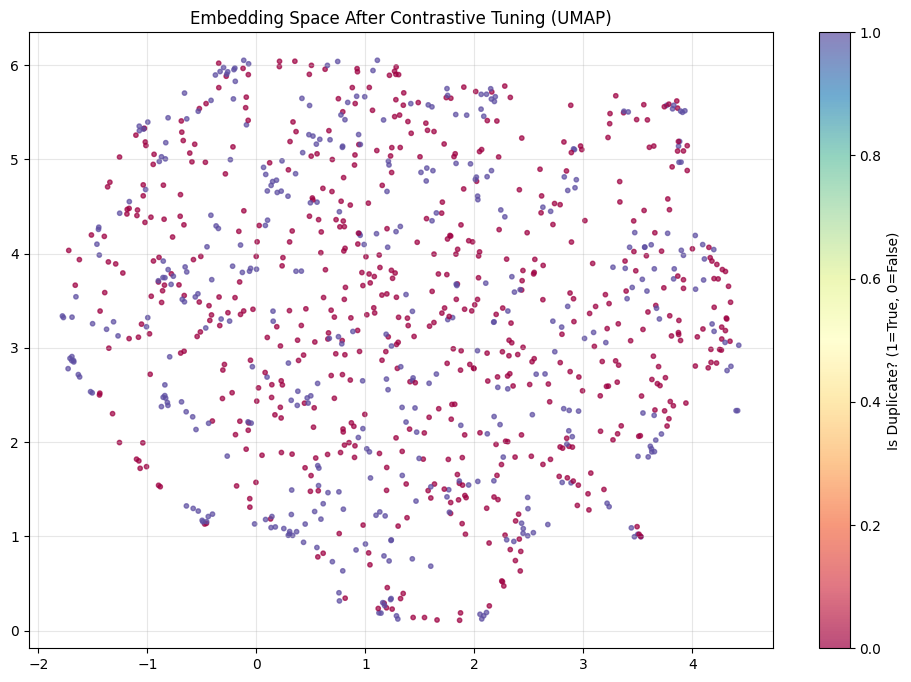


--- Benchmark Comparison ---
Final MRR@10: 0.4489
Baseline MRR@10: 0.4556
Improvement: -0.0068


In [4]:
import matplotlib.pyplot as plt
import umap.umap_ as umap
import numpy as np

# Load the best model saved during training
model = SentenceTransformer('quora-contrastive-model')

def visualize_embeddings(model, dataset, title):
    sentences = []
    labels = []
    
    # Pick a random subset of 1000 questions (500 pairs) for visualization
    subset = dataset.select(range(500))
    
    for row in subset:
        # We append both questions in the pair
        sentences.append(row['question1'])
        sentences.append(row['question2'])
        # We append the duplicate status (0 or 1) as the color label
        labels.append(row['label']) 
        labels.append(row['label'])

    # Encode texts
    embeddings = model.encode(sentences, show_progress_bar=True)
    
    # Reduce dim to 2D using UMAP
    reducer = umap.UMAP(random_state=42)
    embedding_2d = reducer.fit_transform(embeddings)
    
    plt.figure(figsize=(12, 8))
    # Scatter plot: color by duplicate status (1 should cluster tighter)
    scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], 
                          c=labels, 
                          cmap='Spectral', # Good contrast color map
                          s=10, 
                          alpha=0.7)
    plt.colorbar(scatter, label="Is Duplicate? (1=True, 0=False)")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

# Visualize the embedding space after fine-tuning
print("Generating UMAP visualization...")
visualize_embeddings(model, test_dataset, "Embedding Space After Contrastive Tuning (UMAP)")

# Check final metrics
final_results = evaluator(model)

# --- FINAL COMPARISON ---
final_mrr = final_results[BASE_MRR_KEY]

print(f"\n--- Benchmark Comparison ---")
print(f"Final MRR@10: {final_mrr:.4f}")
print(f"Baseline MRR@10: {BASE_MRR_VALUE:.4f}")
print(f"Improvement: {(final_mrr - BASE_MRR_VALUE):.4f}")

In [7]:
import gradio as gr
from sentence_transformers import util

def check_similarity(text1, text2):
    # Encode the two texts
    emb1 = model.encode(text1, convert_to_tensor=True)
    emb2 = model.encode(text2, convert_to_tensor=True)
    
    # Calculate Cosine Similarity
    score = util.cos_sim(emb1, emb2)[0].item()
    
    # Prediction logic (75% similarity is a common threshold for duplicates)
    prediction = "DUPLICATE: High Semantic Similarity" if score > 0.75 else "NOT DUPLICATE: Distinct Meaning"
    
    # Display results
    return f"Similarity Score: {score:.4f}", prediction

iface = gr.Interface(
    fn=check_similarity, 
    inputs=[
        gr.Textbox(label="Question 1 (Anchor)", placeholder="What is the capital of France?"), 
        gr.Textbox(label="Question 2 (Candidate)", placeholder="Where is the main city of France located?")
    ], 
    outputs=[
        gr.Textbox(label="Cosine Similarity Score"), 
        gr.Textbox(label="Model Prediction")
    ],
    title="Quora Contrastive Matcher",
    description="Test the fine-tuned embedding model to see if two questions are semantic duplicates."
)

iface.launch(debug=True)

ModuleNotFoundError: No module named 'gradio'